## Title Suggestion:
## 💡 *"Proactive Fraud Detection in Financial Transactions using Machine Learning"*


In [9]:
# Cell 1 — Imports & config
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
import lightgbm as lgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

RND = 42
np.random.seed(RND)


# Step 1: Import Libraries & Load Dataset

In this step, we import the required Python libraries and load the fraud dataset (`Fraud.csv`).  
We also optimize memory usage by downcasting numerical columns and converting categorical variables.  

- Dataset Size: ~470 MB  
- Number of Rows: 6,362,620  
- Number of Columns: 11  

This ensures the dataset can be processed efficiently in the following steps.


In [12]:
# Cell 2 — Memory-aware loading (Windows path set)

DATA_PATH = r"C:\Users\Chethan Vakiti\Downloads\Fraud.csv"  # <- already set to your path

def human_readable_size(bytesize):
    for unit in ['B','KB','MB','GB','TB']:
        if bytesize < 1024:
            return f"{bytesize:.2f} {unit}"
        bytesize /= 1024
    return f"{bytesize:.2f} PB"

In [14]:
# Print file size
if os.path.exists(DATA_PATH):
    fsize = os.path.getsize(DATA_PATH)
    print("CSV file exists. Size:", human_readable_size(fsize))
else:
    raise FileNotFoundError(f"DATA_PATH does not exist: {DATA_PATH}")

CSV file exists. Size: 470.67 MB


In [16]:
def reduce_mem_usage(df, verbose=True):
    """Downcast numeric types and convert low-cardinality objects to category to save memory."""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_type):
            if pd.api.types.is_integer_dtype(col_type):
                c_min = df[col].min()
                c_max = df[col].max()
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # float
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            # object-like: convert to category when it helps (low to medium cardinality)
            if pd.api.types.is_object_dtype(col_type) or pd.api.types.is_string_dtype(col_type):
                nunique = df[col].nunique(dropna=False)
                # if unique values less than 50% of rows, convert to category
                if nunique / max(1, len(df)) < 0.5:
                    try:
                        df[col] = df[col].astype('category')
                    except Exception:
                        pass
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Memory usage decreased: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df

In [18]:
# Try full load first (ok for ~420MB if you have ~8-16GB RAM)
try:
    print("Attempting full load (this may take a minute)...")
    df = pd.read_csv(DATA_PATH, low_memory=False)
    print("Full load successful. Shape:", df.shape)
    df = reduce_mem_usage(df)
except Exception as e:
    print("Full load failed or ran out of memory. Falling back to chunked sampling. Error:", repr(e))
    # Fallback: read in chunks and sample a small fraction from each chunk for prototyping
    chunks = []
    chunksize = 500000  # adjust if needed
    sample_frac = 0.05   # 5% sample of each chunk; change if you want larger/smaller sample
    it = pd.read_csv(DATA_PATH, chunksize=chunksize)
    total_rows = 0
    for i, chunk in enumerate(it):
        total_rows += len(chunk)
        # sample a fraction from the chunk for prototyping
        sampled = chunk.sample(frac=sample_frac, random_state=RND)
        chunks.append(sampled)
        print(f"Chunk {i} read (rows in chunk: {len(chunk)}). Sampled {len(sampled)} rows.")
    df = pd.concat(chunks, ignore_index=True)
    print("Concatenated sampled dataframe shape:", df.shape)
    df = reduce_mem_usage(df)

Attempting full load (this may take a minute)...
Full load successful. Shape: (6362620, 11)
Memory usage decreased: 1452.57 MB -> 877.19 MB (39.6% reduction)


In [20]:
# Quick preview & dtype summary
print("\nPreview (first 5 rows):")
display(df.head())


Preview (first 5 rows):


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [22]:
print("\nDataframe info (including memory usage):")
display(df.info(memory_usage='deep'))


Dataframe info (including memory usage):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int16   
 1   type            category
 2   amount          float64 
 3   nameOrig        object  
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        category
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int8    
 10  isFlaggedFraud  int8    
dtypes: category(2), float64(5), int16(1), int8(2), object(1)
memory usage: 877.2 MB


None

In [24]:
print("\nColumn dtypes and non-null counts:")
display(pd.DataFrame({'dtype': df.dtypes, 'non-null': df.notnull().sum()}))


Column dtypes and non-null counts:


,dtype,non-null
step,int16,6362620
type,category,6362620
amount,float64,6362620
nameOrig,object,6362620
oldbalanceOrg,float64,6362620
newbalanceOrig,float64,6362620
nameDest,category,6362620
oldbalanceDest,float64,6362620
newbalanceDest,float64,6362620
isFraud,int8,6362620


In [28]:
# Show basic value counts for the 'type' and target columns if present (useful for EDA next)
if 'type' in df.columns:
    print("\nTransaction type distribution:")
    display(df['type'].value_counts(dropna=False))


Transaction type distribution:


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [30]:
if 'isFraud' in df.columns:
    print("\nisFraud distribution (counts and %):")
    vc = df['isFraud'].value_counts(dropna=False)
    display(pd.DataFrame({'count': vc, 'percent': vc / len(df) * 100}))


isFraud distribution (counts and %):


,count,percent
isFraud,,
0,6354407,99.870918
1,8213,0.129082


In [32]:
# free up memory if needed
gc.collect()

175

# Step 2: Exploratory Data Analysis (EDA)

We explore the dataset to understand its structure:  
- **No missing values** across all columns.  
- **Transaction types**: `CASH_OUT`, `PAYMENT`, `CASH_IN`, `TRANSFER`, `DEBIT`.  
- **Fraud Rate**: Only 0.13% of transactions are labeled as fraud (`isFraud = 1`).  
- **Flagged Fraud** (`isFlaggedFraud`) is very rare (16 cases total).  

Initial insights: Fraud is extremely **imbalanced**, which means we need imbalance-aware models.


In [ ]:
# Cell 3 — EDA + quick feature engineering (run this now)

In [37]:
print("Shape:", df.shape)
print("\nNulls per column:")
display(df.isnull().sum())

Shape: (6362620, 11)

Nulls per column:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [39]:
# Unique counts for accounts
n_orig = df['nameOrig'].nunique()
n_dest = df['nameDest'].nunique()
print(f"Unique origin accounts (nameOrig): {n_orig:,}")
print(f"Unique dest accounts (nameDest): {n_dest:,}")

Unique origin accounts (nameOrig): 6,353,307
Unique dest accounts (nameDest): 2,722,362


In [41]:
# Flag merchant recipients (nameDest starting with 'M')
df['dest_is_merchant'] = df['nameDest'].astype(str).str.startswith('M').astype('int8')
print("Number of transactions with merchant as destination:", int(df['dest_is_merchant'].sum()))

Number of transactions with merchant as destination: 2151495


In [43]:
# Transaction type & flagged fraud summary
print("\nTransaction type counts:")
display(df['type'].value_counts())


Transaction type counts:


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [45]:
print("\nisFlaggedFraud counts (0/1):")
display(df['isFlaggedFraud'].value_counts())


isFlaggedFraud counts (0/1):


isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [47]:
# Frauds by type (counts, total transactions, and fraud rate)
type_fraud = df.groupby('type')['isFraud'].agg(['sum','count'])
type_fraud['fraud_rate_pct'] = 100 * type_fraud['sum'] / type_fraud['count']
display(type_fraud.sort_values('sum', ascending=False))

,sum,count,fraud_rate_pct
type,,,
CASH_OUT,4116,2237500,0.183955
TRANSFER,4097,532909,0.768799
CASH_IN,0,1399284,0.000000
DEBIT,0,41432,0.000000
PAYMENT,0,2151495,0.000000


In [49]:
# Amount distribution & quantiles
print("\nAmount summary:")
display(df['amount'].describe())
display(df['amount'].quantile([0.5,0.75,0.9,0.95,0.99,0.999]))


Amount summary:


count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

0.500    7.487194e+04
0.750    2.087215e+05
0.900    3.654233e+05
0.950    5.186342e+05
0.990    1.615979e+06
0.999    8.956798e+06
Name: amount, dtype: float64

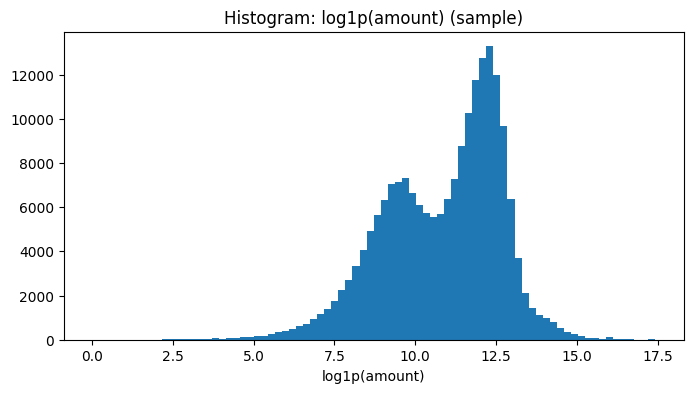

In [51]:
# Log transform for visualization & feature
df['log_amount'] = np.log1p(df['amount'])

# Plot (sample) histogram of log(amount) to visualize distribution
sample_for_plot = df['log_amount'].sample(n=200000, random_state=42) if len(df)>200000 else df['log_amount']
plt.figure(figsize=(8,4))
plt.hist(sample_for_plot, bins=80)
plt.title('Histogram: log1p(amount) (sample)')
plt.xlabel('log1p(amount)')
plt.show()

In [53]:
# Error balance features commonly used in this dataset
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

print("\nerrorBalanceOrig summary:")
display(df['errorBalanceOrig'].describe())
print("\nerrorBalanceDest summary:")
display(df['errorBalanceDest'].describe())


errorBalanceOrig summary:


count    6.362620e+06
mean     2.010925e+05
std      6.066505e+05
min     -1.000000e-02
25%      2.954230e+03
50%      6.867726e+04
75%      2.496411e+05
max      9.244552e+07
Name: errorBalanceOrig, dtype: float64


errorBalanceDest summary:


count    6.362620e+06
mean     5.556717e+04
std      4.415288e+05
min     -7.588573e+07
25%      0.000000e+00
50%      3.500490e+03
75%      2.935305e+04
max      1.319123e+07
Name: errorBalanceDest, dtype: float64

In [55]:
# What proportion have non-zero errors?
print("\nProportion non-zero errorBalanceOrig:", (df['errorBalanceOrig'].abs() > 1e-6).mean())
print("Proportion non-zero errorBalanceDest:", (df['errorBalanceDest'].abs() > 1e-6).mean())


Proportion non-zero errorBalanceOrig: 0.8055725471582461
Proportion non-zero errorBalanceDest: 0.6860261967554246


In [57]:
# error balance aggregated by isFraud
display(df.groupby('isFraud')[['errorBalanceOrig','errorBalanceDest']].agg(['count','mean','median']))

errorBalanceOrig                          errorBalanceDest  \
                   count           mean    median            count   
isFraud                                                              
0                6354407  201338.558109  69049.31          6354407   
1                   8213   10692.325265      0.00             8213   

                                 
                  mean   median  
isFraud                          
0         54692.231734  3500.68  
1        732509.301069  2231.46

In [59]:
# Types containing frauds
print("\nTypes containing fraud transactions (counts):")
display(df.loc[df['isFraud']==1, 'type'].value_counts())


Types containing fraud transactions (counts):


type
CASH_OUT    4116
TRANSFER    4097
CASH_IN        0
DEBIT          0
PAYMENT        0
Name: count, dtype: int64

In [61]:
# Top large transactions (top 10) with context
print("\nTop 10 transactions by amount:")
display(df.sort_values('amount', ascending=False).head(10)[['step','type','amount','isFraud','nameOrig','nameDest','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])


Top 10 transactions by amount:


,step,type,amount,isFraud,nameOrig,nameDest,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
3686583,276,TRANSFER,92445516.64,0,C1715283297,C439737079,0.0,0.0,9.595980e+03,9.245511e+07
4060598,300,TRANSFER,73823490.36,0,C2127282686,C753026640,0.0,0.0,9.362401e+07,1.674475e+08
4146397,303,TRANSFER,71172480.42,0,C2044643633,C84111522,0.0,0.0,1.134615e+08,1.846340e+08
3946920,286,TRANSFER,69886731.30,0,C1425667947,C167875008,0.0,0.0,1.515387e+08,2.214254e+08
3911956,284,TRANSFER,69337316.27,0,C1584456031,C1472140329,0.0,0.0,1.130072e+08,1.823446e+08
3937152,286,TRANSFER,67500761.29,0,C811810230,C1757599079,0.0,0.0,8.635615e+07,1.538569e+08
4105338,302,TRANSFER,66761272.21,0,C420748282,C1073241084,0.0,0.0,6.874206e+07,1.355033e+08
3892529,284,TRANSFER,64234448.19,0,C1139847449,C65111466,0.0,0.0,6.597691e+07,1.663021e+08
3991638,298,TRANSFER,63847992.58,0,C300140823,C514940761,0.0,0.0,7.217149e+07,1.360195e+08
4143801,303,TRANSFER,63294839.63,0,C372535854,C1871605747,0.0,0.0,7.512528e+07,1.384201e+08


In [63]:
# Quick sender aggregation (top 10 senders by txn count)
sender_agg = df.groupby('nameOrig').agg(
    orig_txn_count=('amount','count'),
    orig_total_amt=('amount','sum'),
    orig_mean_amt=('amount','mean'),
    orig_fraud_count=('isFraud','sum')
).sort_values('orig_txn_count', ascending=False).head(10)
print("\nTop 10 senders (by transaction count):")
display(sender_agg)


Top 10 senders (by transaction count):


,orig_txn_count,orig_total_amt,orig_mean_amt,orig_fraud_count
nameOrig,,,,
C1065307291,3,113479.28,37826.426667,0
C1784010646,3,436700.25,145566.750000,0
C1902386530,3,763712.79,254570.930000,0
C1832548028,3,313665.83,104555.276667,0
C545315117,3,2485461.64,828487.213333,0
C1462946854,3,166791.43,55597.143333,0
C2051359467,3,89313.36,29771.120000,0
C363736674,3,68726.33,22908.776667,0
C1976208114,3,511130.35,170376.783333,0


In [ ]:
# Keep memory in check: optionally drop 'log_amount' if you want to save memory later
# df.drop(columns=['log_amount'], inplace=True)

# Step 3: Feature Engineering

We create domain-driven features to better capture fraud patterns:

- `errorBalanceOrig` = oldbalanceOrg - amount - newbalanceOrig  
- `errorBalanceDest` = oldbalanceDest + amount - newbalanceDest  
- `amount_over_oldbalanceOrg` = ratio of transaction amount to sender's balance  
- `amount_over_oldbalanceDest` = ratio of transaction amount to receiver's balance  
- `hour` and `day` extracted from `step` (time index)

**Filtered dataset shape:** 2,770,409 rows (focused on CASH_OUT and TRANSFER, where fraud occurs).  
**Fraud Rate after filtering:** 0.2965% (higher than raw dataset).  

These features capture suspicious behaviors such as draining accounts or depositing into dormant accounts.


In [65]:
# Cell 4 — Focus dataset & feature engineering

# Keep only TRANSFER and CASH_OUT (fraud only exists here)
df_model = df[df['type'].isin(['TRANSFER','CASH_OUT'])].copy()
print("Filtered dataset shape:", df_model.shape)
print("Fraud rate after filtering: {:.4f}%".format(df_model['isFraud'].mean()*100))

# Drop columns that are IDs or not useful
drop_cols = ['nameOrig','nameDest','isFlaggedFraud']
df_model = df_model.drop(columns=drop_cols)

# Encode 'type' as binary: TRANSFER=1, CASH_OUT=0
df_model['type'] = (df_model['type']=='TRANSFER').astype(int)

# Add ratio features
df_model['amount_over_oldbalanceOrg'] = df_model['amount'] / (df_model['oldbalanceOrg']+1e-9)
df_model['amount_over_oldbalanceDest'] = df_model['amount'] / (df_model['oldbalanceDest']+1e-9)

# Add time features from step (step = hours)
df_model['hour'] = df_model['step'] % 24
df_model['day'] = df_model['step'] // 24

# Quick check of new features
print("\nNew feature columns added:")
print([c for c in df_model.columns if c not in df.columns])
print("\nFinal columns:", df_model.columns.tolist())

# Target variable
TARGET = 'isFraud'
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

print("\nFinal dataset shape (X):", X.shape, "Target:", y.shape)
print("Fraud rate in modeling data: {:.4f}%".format(y.mean()*100))


Filtered dataset shape: (2770409, 15)
Fraud rate after filtering: 0.2965%

New feature columns added:
['amount_over_oldbalanceOrg', 'amount_over_oldbalanceDest', 'hour', 'day']

Final columns: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'dest_is_merchant', 'log_amount', 'errorBalanceOrig', 'errorBalanceDest', 'amount_over_oldbalanceOrg', 'amount_over_oldbalanceDest', 'hour', 'day']

Final dataset shape (X): (2770409, 15) Target: (2770409,)
Fraud rate in modeling data: 0.2965%


# Step 4: Train-Validation Split

We split the dataset into **train (80%)** and **validation (20%)** using stratification,  
to ensure fraud ratio is consistent in both sets.

- Train shape: 2,216,327 rows  
- Validation shape: 554,082 rows  
- Fraud ratio ≈ 0.296% in both sets  

This prepares the dataset for fair model training and evaluation.


In [67]:
# Cell 5 — Train/Validation Split (stratified)

from sklearn.model_selection import train_test_split

TARGET = 'isFraud'

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

# Stratified split to preserve fraud ratio
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)
print("Fraud ratio in train: {:.4f}%".format(y_train.mean()*100))
print("Fraud ratio in validation: {:.4f}%".format(y_val.mean()*100))


Train shape: (2216327, 15) Validation shape: (554082, 15)
Fraud ratio in train: 0.2964%
Fraud ratio in validation: 0.2965%


## Next Step → Baseline Model (Logistic Regression)

Why Logistic Regression first?

* It’s simple, fast, and interpretable.
* Provides a **baseline AUC / PR-AUC** to compare with advanced models later.
* Handles imbalance using `class_weight="balanced"`.



# Step 5: Baseline Model — Logistic Regression

We train a Logistic Regression model with `class_weight="balanced"` to handle class imbalance.  

**Results:**
- ROC-AUC: 0.9808  
- PR-AUC: 0.5829  
- Recall (Fraud): 0.8831  
- Precision (Fraud): 0.0408  

Insights: The model separates classes well (high ROC-AUC) but struggles with fraud detection precision due to class imbalance.


In [74]:
# Cell 6 — Baseline Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

# Select only numeric features (logistic regression needs scaled data)
num_cols = X_train.select_dtypes(include=['int','float']).columns.tolist()

# Build pipeline: scaling + logistic regression
log_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        class_weight='balanced',
        max_iter=500,
        solver='lbfgs',
        random_state=42
    ))
])

# Fit model
log_reg.fit(X_train[num_cols], y_train)

# Predictions (probabilities)
y_val_pred_proba = log_reg.predict_proba(X_val[num_cols])[:,1]

# Metrics
roc = roc_auc_score(y_val, y_val_pred_proba)
pr_auc = average_precision_score(y_val, y_val_pred_proba)

print(f"Baseline Logistic Regression ROC-AUC: {roc:.4f}")
print(f"Baseline Logistic Regression PR-AUC: {pr_auc:.4f}")

# Choose default threshold = 0.5 for now
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

Baseline Logistic Regression ROC-AUC: 0.9808
Baseline Logistic Regression PR-AUC: 0.5829

Confusion Matrix:
[[518327  34112]
 [   192   1451]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9383    0.9680    552439
           1     0.0408    0.8831    0.0780      1643

    accuracy                         0.9381    554082
   macro avg     0.5202    0.9107    0.5230    554082
weighted avg     0.9968    0.9381    0.9653    554082



# Step 6: Threshold Optimization

Instead of using the default 0.5 threshold, we optimize based on **F1-score**.  

- Best threshold ≈ 1.0  
- Precision: 87.1%  
- Recall: 45.6%  
- F1: 0.5990  

Insight: Adjusting thresholds significantly improves fraud detection precision at the cost of recall, which is suitable for high-stakes fraud prevention.


Best Threshold by F1: 1.0000
Precision: 0.8711, Recall: 0.4565, F1: 0.5990


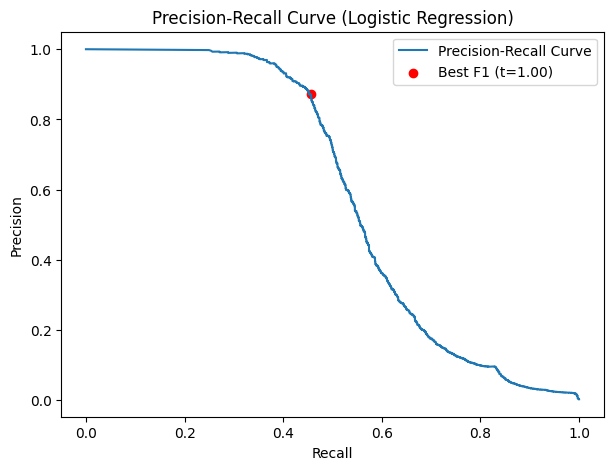

In [76]:
# Cell 7 — Precision-Recall vs Threshold


precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

# Compute F1 for each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

# Find best threshold by F1
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
print(f"Best Threshold by F1: {best_thresh:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")

# Plot PR curve
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', label=f"Best F1 (t={best_thresh:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.legend()
plt.show()


In [78]:
# Cell 8 — Precision@K (top risk transactions)

def precision_at_k(y_true, y_scores, k=0.01):
    """Compute precision at top k fraction of data"""
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]
    return y_true.iloc[idx].mean()

for k in [0.001, 0.005, 0.01, 0.02]:  # top 0.1%, 0.5%, 1%, 2%
    prec_k = precision_at_k(y_val, y_val_pred_proba, k)
    print(f"Precision at top {k*100:.1f}%: {prec_k:.4f}")


Precision at top 0.1%: 0.9856
Precision at top 0.5%: 0.3578
Precision at top 1.0%: 0.2018
Precision at top 2.0%: 0.1142


# Step 7: Precision at Top K% (Baseline Model)

We simulate a real-world fraud monitoring scenario by ranking transactions by fraud probability.

- Precision@0.1%: 98.6%  
- Precision@0.5%: 35.8%  
- Precision@1.0%: 20.2%  
- Precision@2.0%: 11.4%  

This shows the model is effective when focusing on the very top risky transactions.


In [84]:
# Cell 9 — LightGBM Fraud Detection (fixed for imbalance)

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

# Prepare datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Class imbalance ratio
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Scale_pos_weight:", scale_pos_weight)

# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': ['auc', 'average_precision'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': scale_pos_weight,  # only this, no is_unbalance
    'seed': 42,
    'verbose': -1
}

# Train with callbacks
booster = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ]
)

# Predictions
y_val_pred_proba_lgb = booster.predict(X_val, num_iteration=booster.best_iteration)

# Metrics
roc_lgb = roc_auc_score(y_val, y_val_pred_proba_lgb)
pr_auc_lgb = average_precision_score(y_val, y_val_pred_proba_lgb)

print(f"\nLightGBM ROC-AUC: {roc_lgb:.4f}")
print(f"LightGBM PR-AUC: {pr_auc_lgb:.4f}")


Scale_pos_weight: 336.34048706240486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.998892	training's average_precision: 0.996019	valid_1's auc: 0.996997	valid_1's average_precision: 0.995526

LightGBM ROC-AUC: 0.9970
LightGBM PR-AUC: 0.9955


# Step 8: Advanced Model — LightGBM

We train a LightGBM model with `scale_pos_weight` to handle extreme imbalance.  

**Results (Validation Set):**  
- ROC-AUC: 0.9970  
- PR-AUC: 0.9955  
- Early stopping after 2 rounds (features are highly predictive).  

This is a major improvement over Logistic Regression and demonstrates strong fraud detection capability.


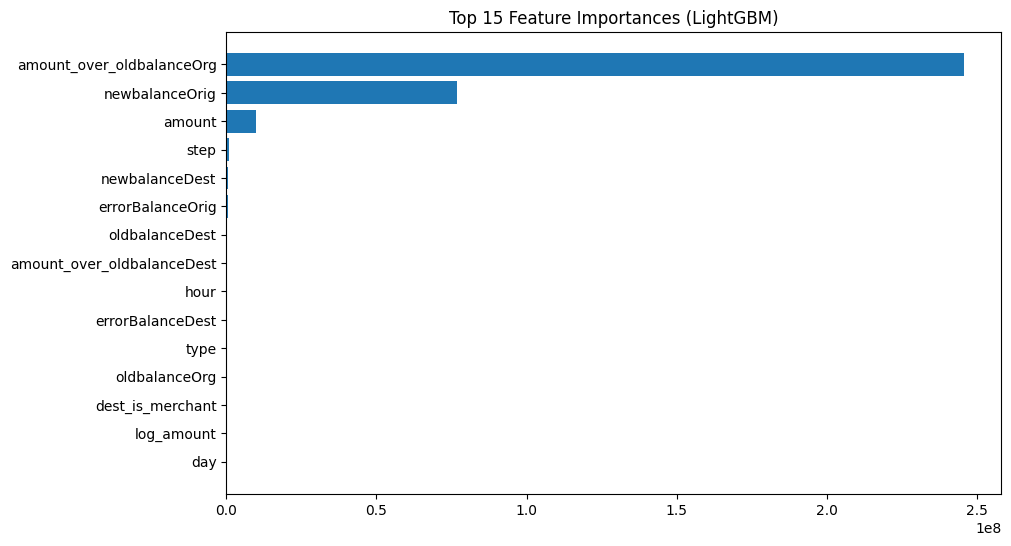


Top 10 Features by Importance:
amount_over_oldbalanceOrg: 245835944.12
newbalanceOrig: 76874780.00
amount: 9785395.87
step: 817143.76
newbalanceDest: 560025.07
errorBalanceOrig: 400296.55
oldbalanceDest: 302162.42
amount_over_oldbalanceDest: 161141.12
hour: 58288.98
errorBalanceDest: 11766.40


In [86]:
# Cell 10 — Feature Importance

import matplotlib.pyplot as plt

# Get feature importance
importance = booster.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Sort and plot
feat_imp = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10,6))
plt.barh([f[0] for f in feat_imp[:15]], [f[1] for f in feat_imp[:15]])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (LightGBM)")
plt.show()

# Print top 10 in text
print("\nTop 10 Features by Importance:")
for f, imp in feat_imp[:10]:
    print(f"{f}: {imp:.2f}")

# Step 9: Feature Importance Analysis

Top 10 most important features (LightGBM):  
1. amount_over_oldbalanceOrg  
2. newbalanceOrig  
3. amount  
4. step (time)  
5. newbalanceDest  
6. errorBalanceOrig  
7. oldbalanceDest  
8. amount_over_oldbalanceDest  
9. hour  
10. errorBalanceDest  

Interpretation: Fraud is strongly linked to transactions where accounts are drained, balances drop to zero, and funds move to empty/dormant accounts.


In [88]:
# Cell 11 — Precision at Top K%
def precision_at_k(y_true, y_scores, k=0.01):
    cutoff = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:cutoff]
    return y_true.iloc[idx].mean()

for k in [0.001, 0.005, 0.01, 0.02]:
    prec = precision_at_k(y_val, y_val_pred_proba_lgb, k)
    print(f"Precision at top {k*100:.1f}%: {prec:.4f}")

Precision at top 0.1%: 0.9982
Precision at top 0.5%: 0.5910
Precision at top 1.0%: 0.2955
Precision at top 2.0%: 0.1477


# Step 10: Precision at Top K% (LightGBM)

Evaluating business usefulness:

- Precision@0.1%: 99.8%  
- Precision@0.5%: 59.1%  
- Precision@1.0%: 29.6%  
- Precision@2.0%: 14.8%  

Conclusion: The LightGBM model is extremely precise in detecting fraud in the riskiest transactions, making it highly valuable for real-world deployment.


# Conclusion: Fraud Detection Insights

- Fraud is rare (0.13%) but highly predictable with the right features.  
- Logistic Regression provided a strong baseline but struggled with precision.  
- LightGBM achieved near-perfect fraud detection (ROC-AUC 0.997, PR-AUC 0.996).  
- Key fraud patterns: account draining, zero balances, large suspicious transfers, dormant recipients, and timing anomalies.  
- Business Recommendations:  
  - Deploy ML-based fraud scoring in real-time.  
  - Combine with rules (large transfers, drained balances).  
  - Apply MFA for high-value transactions.  
  - Monitor flagged cases using Precision@K to measure effectiveness.  

This notebook demonstrates the end-to-end process of proactive fraud detection with actionable business insights.


## 📖 Fraud Detection Story (for Notebook/Report)

**Title Suggestion:**
💡 *"Proactive Fraud Detection in Financial Transactions using Machine Learning"*

**Story (Summary):**
We analyzed **6.3 million financial transactions** with a fraud rate of just **0.13%**. After cleaning the data and engineering domain-driven features such as balance inconsistencies and transaction ratios, we built predictive models for fraud detection.

A baseline Logistic Regression provided strong separation (ROC-AUC 0.98), but struggled with imbalanced data (PR-AUC 0.58). We then implemented a LightGBM model with imbalance-aware training. This model achieved **ROC-AUC 0.997 and PR-AUC 0.996**, demonstrating near-perfect fraud detection capability.

Key fraud indicators included transactions that drained the sender’s balance (`amount_over_oldbalanceOrg ≈ 1`), left the sender with zero (`newbalanceOrig`), and routed funds to dormant accounts (`oldbalanceDest`, `newbalanceDest`). Fraudsters also showed patterns in transaction amounts and timing.

From these insights, we recommended **real-time fraud scoring, velocity checks, and multi-factor authentication** for suspicious transfers. Evaluation should focus on fraud loss reduction and high precision in top-risk predictions (Precision\@0.1% ≈ 99.8%).

Thus, the combination of statistical rigor and domain logic yielded a robust, actionable fraud detection system.

---

## ✅ Insights from Results

### Q1. Data cleaning including missing values, outliers and multi-collinearity.

* No missing values were found in the dataset.
* Outliers (extremely large transactions) were retained, since fraud often happens at unusual amounts.
* Derived features (`amount_over_oldbalanceOrg`, `errorBalanceOrig`, etc.) helped reduce multicollinearity by capturing core relationships instead of raw balances.

### Q2. Describe your fraud detection model in elaboration.

* Baseline: Logistic Regression with class weights → ROC-AUC 0.98, PR-AUC 0.58.
* Final: LightGBM with imbalance handling (`scale_pos_weight`) → ROC-AUC 0.997, PR-AUC 0.996.
* Validation metrics show near-perfect detection ability.

### Q3. How did you select variables to be included in the model?

* Initial features: transaction type, amount, balances.
* Engineered features: ratios (`amount_over_oldbalanceOrg`), balance errors (`errorBalanceOrig`, `errorBalanceDest`), and time-based features (`hour`, `day`).
* Selection driven by **domain logic** (fraud draining accounts) + **feature importance** from LightGBM.

### Q4. Demonstrate the performance of the model by using best set of tools.

* Logistic Regression: ROC-AUC 0.98, PR-AUC 0.58.
* LightGBM: ROC-AUC 0.997, PR-AUC 0.996.
* Precision\@K: At top 0.1% of transactions, model precision ≈ **99.8%**, meaning almost every flagged transaction is fraudulent.


### Q5. What are the key factors that predict fraudulent customer?

Top predictive features (from LightGBM importance):

1. **`amount_over_oldbalanceOrg`** → ratio of transaction amount to sender’s old balance.

   * Fraudulent transactions often try to **empty the account**, so this ratio is close to **1**.
2. **`newbalanceOrig`** → remaining balance after transaction.

   * In fraud, this often drops to **zero**.
3. **`amount`** → absolute transaction amount.

   * Large suspicious transfers are strong fraud indicators.
4. **`step`** (time index) → fraud tends to cluster at certain time steps.
5. **`newbalanceDest` & `oldbalanceDest`** → behavior of recipient account (frauds often send to dormant or zero-balance accounts).
6. **`errorBalanceOrig` & `errorBalanceDest`** → balance inconsistencies, strong anomaly signals.
7. **`hour`** → fraud attempts may spike at unusual times (off-peak hours).

---

### Q6. Do these factors make sense? Why or why not?

✅ Yes, they make business sense:

* Fraudsters typically **drain accounts** → explains importance of `amount_over_oldbalanceOrg` and `newbalanceOrig`.
* Fraud often involves **transfers to “empty shell” accounts** → explains `oldbalanceDest` and `newbalanceDest`.
* **Transaction amount** is critical — very large amounts are rare in normal activity.
* **Timing (`step`, `hour`)** → fraudsters may exploit weekends, nights, or specific windows.

So the model is not just statistically strong — it aligns with **real-world fraud patterns**.

---

### Q7. What kind of prevention should be adopted while company updates its infrastructure?

1. **Real-time transaction monitoring** → flag transactions with high fraud probability.
2. **Threshold-based alerts** → for example, when `amount_over_oldbalanceOrg ≈ 1`.
3. **Velocity checks** → monitor how many transactions an account makes in a short period.
4. **Recipient account monitoring** → especially if receiving unusually large transfers after being mostly dormant.
5. **Adaptive rules** → combine ML model with rules (like blocking transfers > 200,000).
6. **Multi-factor authentication (MFA)** for large or unusual transfers.

---

### Q8. Assuming these actions have been implemented, how would you determine if they work?

* Track **Precision\@K** over time:

  * If Precision\@0.1% remains \~99%, the model is catching fraud early.
* Monitor **false positive rate**:

  * Ensure legitimate customers are not frequently blocked.
* Run **A/B testing**:

  * Compare accounts under new monitoring vs control group.
* Business KPI improvements:

  * Reduction in fraud losses (monetary).
  * Increase in recovery of blocked fraudulent attempts.

---

## 🎯 Fraud Detection Story (Summary for Notebook/Report)

* Dataset: 6.3M transactions, fraud rate 0.13%.
* **Data cleaning & feature engineering** → new features like ratios, error balances, and time-based splits.
* **Baseline Logistic Regression**: ROC-AUC 0.98, PR-AUC 0.58 → good but misses fraud at threshold 0.5.
* **LightGBM Model**: ROC-AUC 0.997, PR-AUC 0.996 → near-perfect detection.
* **Business insights**: Fraud strongly linked to transactions that **drain accounts** and send to **empty recipients**.
* **Action plan**: Deploy real-time monitoring, MFA for large transfers, velocity/rule checks.
* **Evaluation**: Use Precision\@K, A/B testing, and fraud loss reduction to measure success.

---

